In [25]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
from joblib import dump

from os.path import join, basename, exists
from os import makedirs, listdir, mkdir
from shutil import rmtree

import numpy as np
import pyshark
from traceback import print_exc
import csv
import concurrent.futures
from joblib import load
import nest_asyncio
from itertools import product
import matplotlib.pyplot as plt

DATA_DIR = join("data")
PCAP_D = join(DATA_DIR, "pcap")
CSV_D = join(DATA_DIR, "csv")
MODELS_D = join(DATA_DIR, "models")
INTERVALS_D = join(CSV_D, "intervals")
ANOMALIES_D = join(CSV_D, "anomalies")

for d in (DATA_DIR, PCAP_D, CSV_D, MODELS_D, INTERVALS_D, ANOMALIES_D):
        makedirs(d, exist_ok=True)

PCAP = {"1": join(PCAP_D, "mega104-17-12-18.pcapng"),
        "2": join(PCAP_D, "10122018-104Mega.pcapng"),}

CSV = {"1": join(CSV_D, "mega104-17-12-18.csv"),
       "2": join(CSV_D, "10122018-104Mega.csv"),}

nest_asyncio.apply()

In [2]:
def parse(num=1):
    pcap_file = PCAP[str(num)]
    print(f"Reading from {pcap_file}")
    packets = pyshark.FileCapture(pcap_file)

    parsed_data = [("asdu_len", "io_type", "type_id", "src", "dst", "intervl", "relative_time_stamp")]
    
    previous = 0
    first_time_stamp = packets[0].sniff_time
    relative_time = 0
    interval = 0
    hosts = {}
    next_index = 0
    for p in packets:
        if "iec60870_104" not in [l.layer_name for l in p.layers]:
            continue
        
        # Count time from the previous IEC 104 packet
        if previous != 0:
            interval = float((p.sniff_time - previous).total_seconds())
            relative_time = (p.sniff_time - first_time_stamp).total_seconds()
        if p.ip.src not in hosts.keys():
            hosts[p.ip.src] = next_index
            next_index += 1
        if p.ip.dst not in hosts.keys():
            hosts[p.ip.dst] = next_index
            next_index += 1
        
        src = hosts[p.ip.src]
        dst = hosts[p.ip.dst]
        
        previous = p.sniff_time
        # Extract only one 'representative' for the current package
        asdu_layer = p.get_multiple_layers("iec60870_asdu")
        if len(asdu_layer) == 0:
            continue
        asdu_layer = asdu_layer[0]

        iec_header_layer = p.get_multiple_layers("iec60870_104")
        # Aggregate values if more then one header is present in the packet
        iec_header = iec_header_layer[0]
        try:
            iec_header.apdulen = int(iec_header.apdulen)
        except AttributeError:
            # Not all APDU has valid apdulen attribute. Those packets in
            # Wireshark displayed as a byte sequence, so this packet can
            # be parsed
            print("Error in converting the value in packet")
            print_exc()
            print(p)
            continue

        if len(iec_header_layer) != 1:
            for entry in iec_header_layer[1:]:
                iec_header.apdulen += int(entry.apdulen)

        try:
            if asdu_layer:
                parsed_data.append((iec_header.apdulen, asdu_layer.ioa, asdu_layer.typeid, src, dst, interval, relative_time))
        except:
            # Ignoring error if data can't be appended for some reasons.
            print("Error in parsing the packet")
            print_exc()
            print(p)

    with open(CSV[str(num)], "w") as f:
        writer = csv.writer(f)
        writer.writerows(parsed_data)

    print(f"CSV file is stored into {CSV[str(num)]}")


In [3]:
def create_model(num=1, nu=0.018, kernel = 'sigmoid', gamma="scale", out=True):
    
    out_dir = join(MODELS_D, kernel)
    if not exists(out_dir):
        mkdir(out_dir)
    iec104 = pd.read_csv(CSV[str(num)], header=0, skipinitialspace=True)

    iec104 = iec104.drop(columns=["relative_time_stamp"])
    x_train, x_test = train_test_split(iec104, train_size=2/3, test_size=1/3,
                                    shuffle=False, random_state=0)
    one_class_svm = OneClassSVM(nu=nu, kernel=kernel, gamma=gamma).fit(x_train)
    
    if not exists(out_dir):
        mkdir(out_dir)
    
    dump(one_class_svm, join(out_dir, f"oc-svm-{num}-nu-{nu:.3f}-{gamma}.joblib"))
    prediction = one_class_svm.predict(x_test)
    size = len(prediction)
    t = [i for i in prediction if i == -1]
    anomalies = len(t)
    t = [i for i in prediction if i == 1]
    ok = len(t)
    perc_anom = anomalies/size
    if out:
        print("-"*(len(f"Datset: {CSV[str(num)]}") + 2))
        print(f"Datset: {CSV[str(num)]}")
        print(f"Kernel: {kernel}")
        print(f"Nu: {nu:.4f}")
        print(f"Gamma: {gamma}")
        print(f"Total number of samples: {size}")
        print(f"Normal: {ok} ({100*(1-perc_anom):.2f}%)")
        print(f"Anomalies: {anomalies} ({100*perc_anom:.2f}%)")
        print("-"*(len(f"Datset: {CSV[str(num)]}") + 2))

    return [num, kernel, nu, gamma, perc_anom, 1 - perc_anom]

In [4]:
def predict(model, nu, dataset, out=True, kernel="rbf", gamma="scale"):
    model = join(MODELS_D, kernel, f"oc-svm-{model}-nu-{nu}-{gamma}.joblib")

    svm = load(model)
    data = pd.read_csv(dataset).drop(columns=["relative_time_stamp"])

    prediction = svm.predict(data)
    size = len(prediction)
    t = [i for i in prediction if i == -1]
    anomalies = len(t)
    t = [i for i in prediction if i == 1]
    ok = len(t)
    perc_anom = anomalies/size

    if out:
        print("-"*(len(f"Total number of samples: {size}") + 2))
        print(f"Datset: {dataset}")
        print(f"Total number of samples: {size}")
        print(f"Normal: {ok} ({100*(1-perc_anom):.2f}%)")
        print(f"Anomalies: {anomalies} ({100*perc_anom:.2f}%)")
        print("-"*(len(f"Total number of samples: {size}") + 2))
    # return prediction, (size, ok, 100*(1-perc_anom), anomalies, 100*perc_anom)

    return prediction


In [5]:
def get_interval(i, interval, model_num, type_="o"):
    f = join(INTERVALS_D, f"model-{model_num}-{interval}min", f"frame-{model_num}-{i}.csv") if type_ == "o" else join(ANOMALIES_D, f"frame-{model_num}-{i}.csv")
    assert exists(f), f"File {f} does not exists"
    return f


In [8]:
def create_anomalies(i, interval, model_num):
    frame_name = get_interval(i, interval, model_num, type_="o")
    dst = join(ANOMALIES_D, basename(frame_name))
    frame = pd.read_csv(frame_name)

    rc = {"frame":dst, "indexes": [], "values": None, "start_index": None}

    row_num = frame.shape[0]
    # generate 15 random indexes to change size of data
    min_size = frame["asdu_len"].min()
    max_size = frame["asdu_len"].max()

    if min_size < max_size:
        rc["indexes"] = np.random.randint(0, row_num, size=int(row_num*0.1))
        rc["values"] = np.random.randint(min_size, max_size, int(row_num*0.1))
        frame.loc[rc["indexes"], ["asdu_len"]] = rc["values"]

    rc["start_index"] = np.random.randint(0, row_num-int(row_num*0.2))
    range_ = pd.RangeIndex(rc["start_index"], rc["start_index"] + int(row_num*0.2))

    src = frame.loc[range_, "src"]
    frame.loc[range_, "src"] = frame.loc[range_, "dst"]
    frame.loc[range_, "dst"] = src
    frame.to_csv(rc["frame"], index=False)
    
    rc["indexes"] = np.append(rc["indexes"], range_)

    return rc


In [7]:
def split_to_intervals(model_num, interval="5min"):
    interval_dir = join(INTERVALS_D, f"model-{model_num}-{interval}")
    if exists(interval_dir):
        rmtree(interval_dir)
    
    mkdir(interval_dir)

    data = pd.read_csv(CSV[model_num])
    data["relative_time_stamp"] = pd.to_datetime(data["relative_time_stamp"], unit='s',)
    for i, frame in enumerate(data.groupby(pd.Grouper(key="relative_time_stamp",freq=interval))):
        frame[1].to_csv(join(interval_dir, f"frame-{model_num}-{i}.csv"), index=False, date_format="%M:%S.%f")
    return interval_dir

In [114]:
# Check different Nu parameter for the training of the data
# nu = 0.002
nus = np.arange(0.015, 0.021, 0.001)
gammas = ["auto", "scale", 0.1]
result = []

def train(nu):
        for g in gammas:
                for kernel in ["rbf", "sigmoid"]:
                        e_1 = create_model(1, nu=nu, kernel=kernel, gamma=g, out=False)[4:]
                        e_2 = create_model(2, nu=nu, kernel=kernel, gamma=g, out=False)[4:]
                        entry = (nu, kernel, g, *e_1, *e_2)
                        result.append(entry)

with concurrent.futures.ThreadPoolExecutor(max_workers=len(nus)) as executor:
        executor.map(train, nus)

df = pd.DataFrame(result, columns=["nu", "kernel", "gamma", "false_positive_1", "acc_1", "false_positive_2", "acc_2"])
df_sorted = df.sort_values(by=['nu'], ascending=False).reset_index(drop=True)

In [115]:
print(df_sorted)

       nu   kernel  gamma  false_positive_1     acc_1  false_positive_2  \
0   0.021      rbf    0.1          0.023260  0.976740          0.016632   
1   0.021  sigmoid    0.1          1.000000  0.000000          1.000000   
2   0.021      rbf  scale          0.018002  0.981998          0.097487   
3   0.021  sigmoid  scale          0.021985  0.978015          0.024451   
4   0.021      rbf   auto          0.033694  0.966306          0.365769   
5   0.021  sigmoid   auto          1.000000  0.000000          1.000000   
6   0.020      rbf    0.1          0.017285  0.982715          0.172467   
7   0.020      rbf  scale          0.017684  0.982316          0.097487   
8   0.020  sigmoid    0.1          1.000000  0.000000          1.000000   
9   0.020  sigmoid  scale          0.020870  0.979130          0.022824   
10  0.020      rbf   auto          0.041899  0.958101          0.313025   
11  0.020  sigmoid   auto          1.000000  0.000000          1.000000   
12  0.019  sigmoid   auto

In [118]:
dfs = df_sorted.drop(columns=["acc_1", "acc_2"]).loc[(df_sorted["false_positive_1"] < 0.03) & (df_sorted["false_positive_2"] < 0.03)].sort_values(by=['nu'], ascending=True).reset_index(drop=True)
print(dfs)

      nu   kernel  gamma  false_positive_1  false_positive_2
0  0.015  sigmoid  scale          0.015852          0.017265
1  0.016  sigmoid  scale          0.016728          0.018575
2  0.017  sigmoid  scale          0.017604          0.019434
3  0.017      rbf    0.1          0.023339          0.018711
4  0.018  sigmoid  scale          0.018878          0.020745
5  0.019  sigmoid  scale          0.020073          0.021784
6  0.020  sigmoid  scale          0.020870          0.022824
7  0.021      rbf    0.1          0.023260          0.016632
8  0.021  sigmoid  scale          0.021985          0.024451


In [122]:
dfs.style.to_latex(join(CSV_D, "summary.csv"), encoding="utf-8")

In [49]:
nu = 0.01
model_nums = ["1", "2"]
gammas = ["auto", "scale", 0.1]
kernels = ["linear", "rbf", "sigmoid"]
summary = []

with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    for r in executor.map(create_model, *zip(*product(model_nums, [nu], kernels, gammas))):
        summary.append(r)
summary = pd.DataFrame(summary, columns=["model", "kernel", "nu", "gamma", "anomalies", "normal"])

---------------------------------------
Datset: data/csv/mega104-17-12-18.csv
Kernel: sigmoid
Nu: 0.0170
Gamma: auto
Total number of samples: 12554
Normal: 0 (0.00%)
Anomalies: 12554 (100.00%)
---------------------------------------
---------------------------------------
Datset: data/csv/mega104-17-12-18.csv
Kernel: linear
Nu: 0.0170
Gamma: auto
Total number of samples: 12554
Normal: 12333 (98.24%)
Anomalies: 221 (1.76%)
---------------------------------------
---------------------------------------
Datset: data/csv/mega104-17-12-18.csv
Kernel: sigmoid
Nu: 0.0170
Gamma: 0.1
Total number of samples: 12554
Normal: 0 (0.00%)
Anomalies: 12554 (100.00%)
---------------------------------------
---------------------------------------
Datset: data/csv/mega104-17-12-18.csv
---------------------------------------Kernel: linear

Nu: 0.0170
Datset: data/csv/mega104-17-12-18.csv
Kernel: linear
Nu: 0.0170
Gamma: 0.1
Total number of samples: 12554
Normal: 12333 (98.24%)
Anomalies: 221 (1.76%)
------

In [50]:
print(summary)

   model   kernel     nu  gamma  anomalies    normal
0      1   linear  0.017   auto   0.017604  0.982396
1      1   linear  0.017  scale   0.017604  0.982396
2      1   linear  0.017    0.1   0.017604  0.982396
3      1      rbf  0.017   auto   0.051697  0.948303
4      1      rbf  0.017  scale   0.014896  0.985104
5      1      rbf  0.017    0.1   0.023339  0.976661
6      1  sigmoid  0.017   auto   1.000000  0.000000
7      1  sigmoid  0.017  scale   0.017604  0.982396
8      1  sigmoid  0.017    0.1   1.000000  0.000000
9      2   linear  0.017   auto   0.019434  0.980566
10     2   linear  0.017  scale   0.019434  0.980566
11     2   linear  0.017    0.1   0.019434  0.980566
12     2      rbf  0.017   auto   0.227289  0.772711
13     2      rbf  0.017  scale   0.097487  0.902513
14     2      rbf  0.017    0.1   0.018711  0.981289
15     2  sigmoid  0.017   auto   1.000000  0.000000
16     2  sigmoid  0.017  scale   0.019434  0.980566
17     2  sigmoid  0.017    0.1   1.000000  0.

In [8]:
frame_num = 3
_, (ind, vals), i = create_anomalies(frame_num)
frame_anom = get_interval(frame_num, type_='a')

res = predict(num, 0.017, frame_anom)
anoms_an = [i for i, n in enumerate(res) if n == -1]
all_data = pd.read_csv(frame_anom)

anoms_real = sorted([i for i in anoms_an if i not in anoms_ok])
print(f"Created {len(ind)}: {sorted(ind)}")
print(f"Detected {len(anoms_real)}: {anoms_real}")
print(f"{len(ind)/len(anoms_real):.02f}%")

TypeError: create_anomalies() missing 2 required positional arguments: 'interval' and 'model_num'

### Accuracy of original datasets

In [10]:
summary = []
nu = 0.017
kernel = "sigmoid"
for interval in [5, 7, 10]:
    for model_num in ['1', '2']: 
        intervals_dir = split_to_intervals(model_num, f"{interval}min")

        # Prediction
        frames = [f for f in listdir(intervals_dir) if f"frame-{model_num}" in f]
        result_acc = []
        for f in frames:
            fr = join(intervals_dir, f)
    
            # df = pd.read_csv(fr)
            gen_labels = predict(model_num, nu, fr, out=False, kernel=kernel)
            real_labels = np.ones(len(gen_labels), dtype=int)

            result_acc.append((fr, accuracy_score(real_labels, gen_labels)))
        
        result_acc = pd.DataFrame(result_acc, columns=["dataframe", "accuracy"])
        max_acc = result_acc[(result_acc.accuracy == result_acc.accuracy.max())]
        tmp = (model_num, kernel, interval,
                result_acc.accuracy.min(),
                max_acc.shape[0],
                (max_acc.shape[0]/result_acc.shape[0])*100,
                result_acc.accuracy.mean())
        summary.append(tmp)
summary = pd.DataFrame(summary, columns=["model number", "kernel", "interval", "min acc",  "num 100 acc", "% 100 acc", "mean acc"])

In [11]:
grouped_df = summary.groupby("interval")
for key, item in grouped_df:
    # grouped_df.get_group(key).to_latex(index=False)
    print(grouped_df.get_group(key), "\n\n")

  model number   kernel  interval   min acc  num 100 acc  % 100 acc  mean acc
0            1  sigmoid         5  0.897436          651  79.779412  0.995043
1            2  sigmoid         5  0.988117            1   1.694915  0.994532 


  model number   kernel  interval   min acc  num 100 acc  % 100 acc  mean acc
2            1  sigmoid         7  0.921569          420  72.041166   0.99503
3            2  sigmoid         7  0.991520            1   2.380952   0.99455 


  model number   kernel  interval   min acc  num 100 acc  % 100 acc  mean acc
4            1  sigmoid        10  0.942029          261  63.970588  0.995074
5            2  sigmoid        10  0.989290            1   3.333333  0.994445 




In [9]:
def job(nu, model_num, interval, kernel, gamma):
    interval_dir = join(INTERVALS_D, f"model-{model_num}-{interval}min")
    all_frames = [f for f in listdir(interval_dir) if f"frame-{model_num}" in f]
    indexes = np.random.randint(0, len(all_frames), size=int(len(all_frames)*0.2))
    summary = []
    if type(nu) == float:
        nu = f"{nu:.3f}"
    
    for i in indexes:
        try:
            result = create_anomalies(i, interval, model_num)
        except AssertionError as e:
            continue
        ok_frame = get_interval(i, interval, model_num)

        first_prediction = predict(model_num, nu=nu, dataset=ok_frame,
                                    kernel=kernel, gamma=gamma, out=False)
        prediction = predict(model_num, nu=nu, dataset=result["frame"],
                                    kernel=kernel, gamma=gamma, out=False)
        real = np.ones(len(prediction), dtype=int)  # real labels
        
        anomaly_real_count = len(result["indexes"])  # how much anomalies are in the interval
        anomaly_real_perc =  (anomaly_real_count/len(first_prediction))*100
        anomaly_detected = (1 - accuracy_score(first_prediction, prediction)) * 100
        not_detected = anomaly_real_perc - anomaly_detected
        false_positives = (1 - accuracy_score(real, first_prediction)) * 100

        summary.append((model_num, interval, kernel, nu, gamma,
                        anomaly_detected, anomaly_real_perc, not_detected, false_positives))
    # print(summary)
    return summary


In [47]:
# nus = np.arange(0.005, 0.021, 0.001)
result = []
nus = [0.017, 0.021]
kernels    = ["rbf", "sigmoid"]
intervals  = [5, 7, 10]
model_nums = ["1", "2"]
gammas = ["scale", 0.1]

for r in map(job, *zip(*product(nus, model_nums, intervals, kernels, gammas))):
    result += r

result = pd.DataFrame(result, columns=["model", "interval", "kernel", "nu", "gamma", "anom_detected", "anom_perc", "not_detected", "false_positives"])


In [56]:
models_ = result.groupby(["nu", "kernel", "interval", "gamma" ])

print(models_["not_detected"].mean().unstack([1,3]))
# models_["not_detected"].mean().unstack([1,3]).style.to_latex(join(DATA_DIR, "not-detected-mean.tex"), encoding="utf-8")
# models_["not_detected"].max().unstack([1,3]).style.to_latex(join(DATA_DIR, "not-detected-max.tex"), encoding="utf-8")

print(models_["not_detected"].max().unstack([1,3]))

kernel               rbf               sigmoid           
gamma                0.1      scale        0.1      scale
nu    interval                                           
0.017 5         1.398489  21.420100  21.527331   9.512613
      7         1.473942  21.749738  23.096061  11.205972
      10        2.039134  23.496930  24.322280  11.923516
0.021 5         1.263915  21.281265  21.588278  11.281149
      7         1.406228  21.574253  22.051360  11.850376
      10        2.042682  22.643155  23.518404  13.655174
kernel                rbf            sigmoid           
gamma                 0.1      scale     0.1      scale
nu    interval                                         
0.017 5          9.375000  29.577465    30.0  29.746835
      7          7.142857  30.000000    30.0  29.641694
      10         7.058824  30.000000    30.0  29.764652
0.021 5         12.500000  30.000000    30.0  29.852744
      7         12.000000  29.569191    30.0  29.817708
      10         7.017544  29.

In [30]:
models_ = result.groupby(["nu", "kernel", "interval", "gamma" ])
r_ =  models_["not_detected"].mean()
print(r_)


nu     kernel   interval  gamma
0.017  rbf      5         0.1       1.897507
                          scale    18.642617
                7         0.1       2.196811
                          scale    19.820621
                10        0.1       1.894156
                          scale    21.082028
       sigmoid  5         0.1      78.277670
                          scale     8.814422
                7         0.1      77.109207
                          scale     8.711453
                10        0.1      76.709609
                          scale    10.649333
0.021  rbf      5         0.1       1.972456
                          scale    18.847738
                7         0.1       2.272380
                          scale    19.589995
                10        0.1       2.126934
                          scale    19.916514
       sigmoid  5         0.1      78.328666
                          scale     9.037084
                7         0.1      77.556521
                       

In [28]:
r_df = r_.to_frame().unstack([1,3])
r_df.style.to_latex(join(DATA_DIR, "unstack.tex"), encoding="utf-8")

In [128]:
models = result.groupby(["nu", "kernel", "interval", "gamma" ])
r =  models["not_detected"].mean().unstack([1,3])
print(r)
r.to_latex(join(DATA_DIR, "validation.tex"), encoding='utf-8')

nu     kernel   interval  gamma
0.017  rbf      5         0.1       2.745209
                          auto      7.736840
                          scale    20.016600
                7         0.1       2.076709
                          auto      7.764979
                          scale    20.208150
                10        0.1       1.250617
                          auto      5.795524
                          scale    21.638794
       sigmoid  5         0.1      76.076087
                          auto     76.076087
                          scale    13.314455
                7         0.1      74.788891
                          auto     74.788891
                          scale    14.726779
                10        0.1      74.201924
                          auto     74.201924
                          scale    15.282397
0.021  rbf      5         0.1       3.403086
                          auto     10.733861
                          scale    19.648495
                7      

/tmp/ipykernel_43212/3095950487.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  r.to_latex(join(CSV_D, "validation.tex"), encoding='utf-8')


In [34]:
models_["not_detected"].max().unstack([1,3]).style.to_latex(join(DATA_DIR, "max.tex"), encoding="utf-8")

In [67]:
r = create_anomalies("1", "5", "1")
anoms = pd.read_csv(r["frame"])
orig = pd.read_csv(get_interval("1", "5", "1"))


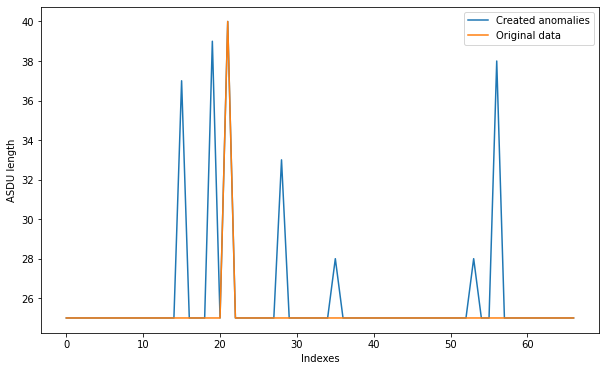

<Figure size 432x288 with 0 Axes>

In [70]:
plt.figure(figsize=(10,6))
anoms["asdu_len"].plot()
orig["asdu_len"].plot()

plt.legend(["Created anomalies", "Original data"], loc=1);
plt.xlabel("Indexes")
plt.ylabel("ASDU length")
plt.savefig("anomalies.png")
plt.show()
